In [1]:
import seaborn as sns
import jax
import ott
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from entot.data.data import MixtureNormalSampler
from entot.plotting.plots import plot_1D_unbalanced

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: I

In [2]:
source = MixtureNormalSampler(jax.random.PRNGKey(0), [-2.5, 1.0], 1,  0.2, batch_size=1024)
target = MixtureNormalSampler(jax.random.PRNGKey(1), [-1.0,1.0, 5.0], 1,  0.1, batch_size=1024)

In [3]:
epsilon = 5e-2
tau_a = 1.0
tau_b = 1.0

In [4]:
neural_net = MLP_vector_field(1, latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(1, 1)

mlp_eta = MLP_marginal(256, 5)
mlp_xi = MLP_marginal(256, 5)

ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()

otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, epsilon=epsilon, mlp_eta=mlp_eta, mlp_xi=mlp_xi, tau_a=tau_a, tau_b=tau_b, input_dim=1, output_dim=1, iterations=10_000, k_noise_per_x=1)

In [5]:
otfm(source, target)

100%|██████████| 10000/10000 [09:46<00:00, 17.05it/s]


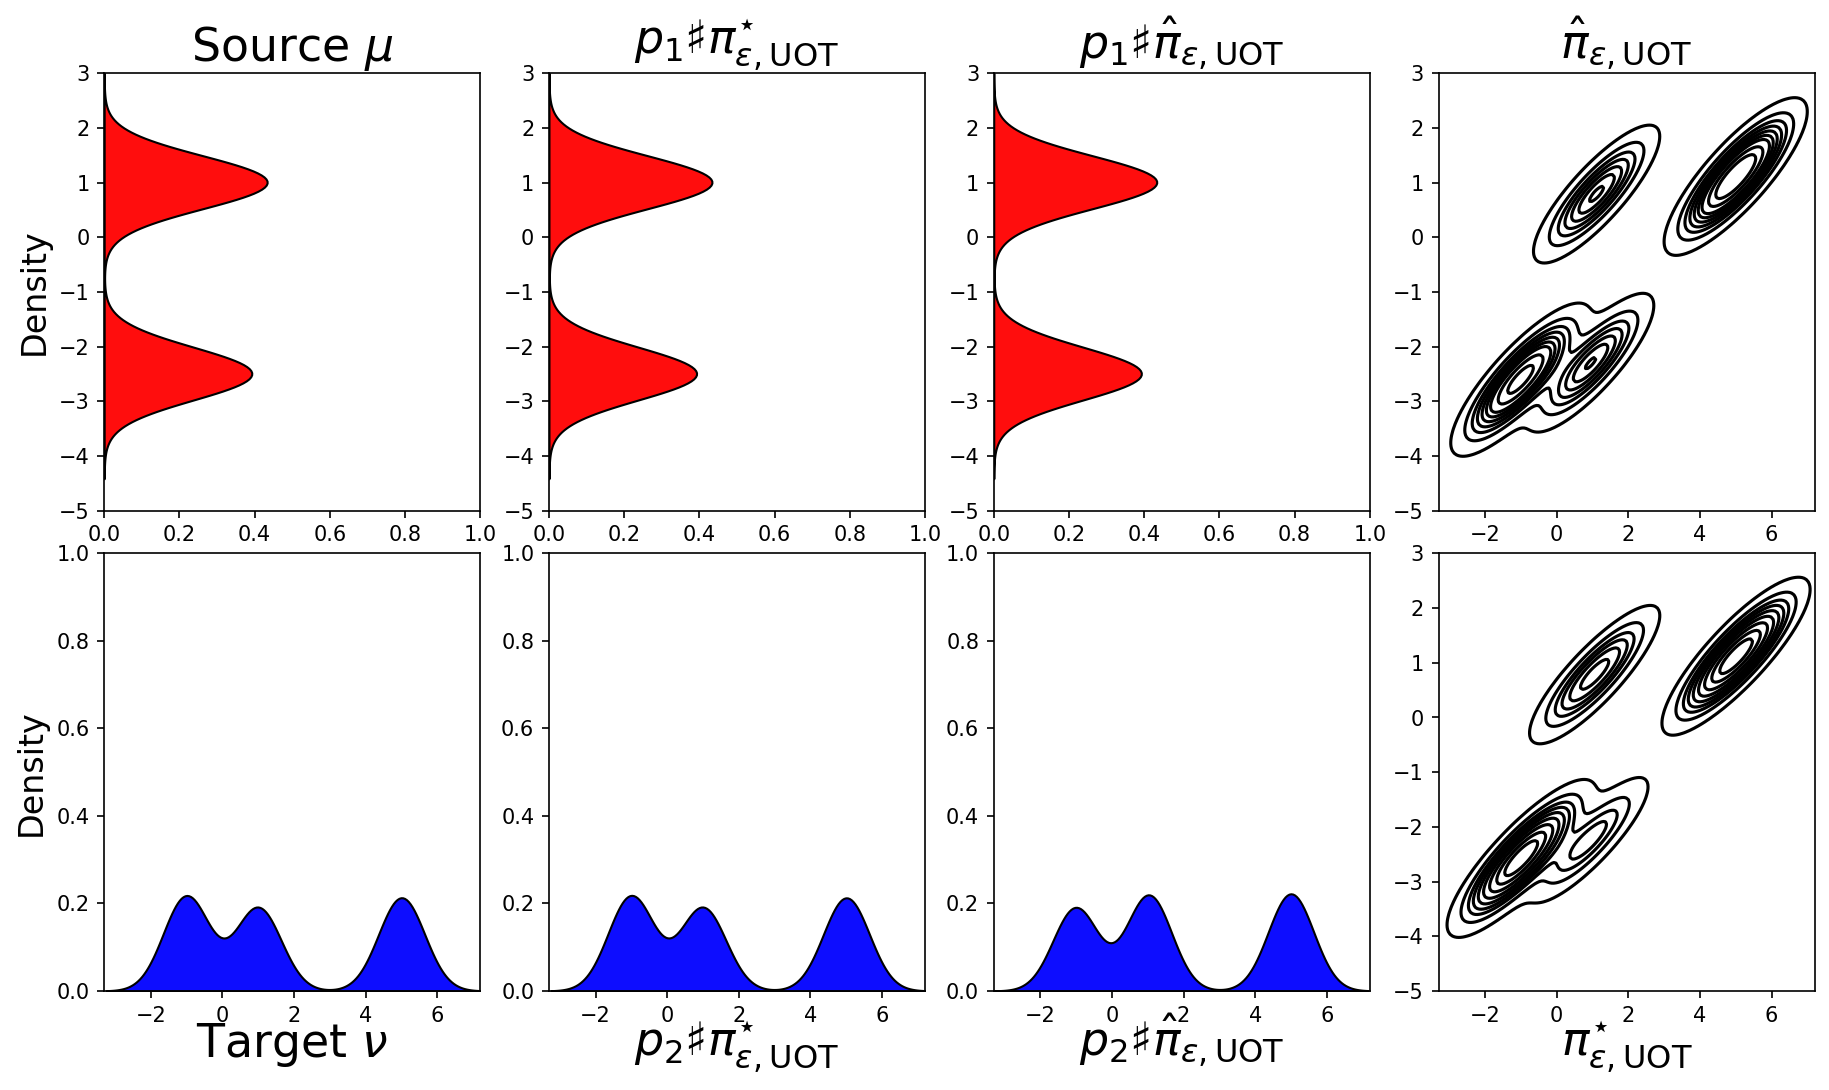

In [6]:
kwargs = {}
a = (-5.0, 3.0) # source support
b = (0.0, 1.0) # density plot
c = (0.0, 4.0)
d = (-3.3, 7.2) # target support
kwargs["00_xlim"] = b
kwargs["01_xlim"] = b
kwargs["02_xlim"] = b
kwargs["03_xlim"] = d
kwargs["10_xlim"] = d
kwargs["11_xlim"] = d
kwargs["12_xlim"] = d
kwargs["13_xlim"] = d

kwargs["00_ylim"] = a
kwargs["01_ylim"] = a
kwargs["02_ylim"] = a
kwargs["03_ylim"] = a
kwargs["10_ylim"] = b
kwargs["11_ylim"] = b
kwargs["12_ylim"] = b
kwargs["13_ylim"] = a

source_batch = next(source)
target_batch = next(target)

rescale_source = otfm.state_eta.apply_fn({"params": otfm.state_eta.params}, source_batch)
rescale_target = otfm.state_xi.apply_fn({"params": otfm.state_xi.params}, target_batch)

res, _, _ = otfm.transport(source_batch, seed=1, diffeqsolve_kwargs={"max_steps": 1_000_000})

_  = plot_1D_unbalanced(source_batch, target_batch, res[0,...], rescale_source, rescale_target, epsilon=epsilon, tau_a=tau_a, tau_b=tau_b, seed=1, figsize=(12, 7), dpi=150, **kwargs)

In [7]:
from functools import partial

In [9]:
source = jnp.array([[0.9]])
fn_partial = partial(
            otfm.state_neural_net.apply_fn, {"params": otfm.state_neural_net.params}, condition=source,
        )
key = jax.random.PRNGKey(0)

In [13]:
x_1 = jnp.linspace(-5.0, 7.0, 100)[:, None]

In [14]:
def approx_logp_wrapper(t, y, args):
    y, _ = y
    *args, eps, func = args
    fn = lambda x: func(t=t, latent=x)
    f, vjp_fn = jax.vjp(fn, y)
    (eps_dfdy,) = vjp_fn(eps)
    logp = jnp.sum(eps_dfdy * eps)
    return f, logp
    
term = diffrax.ODETerm(approx_logp_wrapper)

solver = diffrax.Tsit5()

In [15]:
x1_f1_stacked = (jnp.atleast_2d(x_1), 0.0) #0.0 is the initial condition for the second argument of the augmented neural ODE


In [18]:
save_times = jnp.linspace(0, 1, 6)
saveat = diffrax.SaveAt(ts=save_times)

In [29]:
t1=1.0
t0=0.0
dt0=0.05
eps = jax.random.normal(key, x_1.shape)
t_0 = jnp.ones_like(x_1) * 0.0
t_1 = jnp.ones_like(x_1) * 1.0

In [476]:
def compute_densities(source: jnp.ndarray, compute_densities_at: jnp.ndarray, rng: jax.Array):

    def normal_log_likelihood(y):
        return -0.5 * (y.size * math.log(2 * math.pi) + jnp.sum(y**2))

    def compute_p(target: jnp.ndarray, eps: jnp.ndarray):
        def approx_logp_wrapper(t, y, args):
            y, _ = y
            *args, eps, func = args
            fn = lambda x: func(t=t, latent=x)
            f, vjp_fn = jax.vjp(fn, y)
            (eps_dfdy,) = vjp_fn(eps)
            logp = jnp.sum(eps_dfdy * eps)
            return f, logp
        
        fn_partial = partial(
                otfm.state_neural_net.apply_fn, {"params": otfm.state_neural_net.params}, condition=source,
            )
        
        term = diffrax.ODETerm(approx_logp_wrapper)
        t0=0.0
        t1=1.0
        dt0=0.0001
        eps = jnp.atleast_2d(eps)
        target = jnp.atleast_2d(target)
        x1_f1_stacked = (target, 0.0)
        saveat =  diffrax.SaveAt(ts=jnp.linspace(1, 0, 11))
    
        sol = diffrax.diffeqsolve(
            term, solver, t1, t0, -dt0, x1_f1_stacked, (eps, fn_partial), saveat=saveat, max_steps=1_000_000, stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6)
        )
        return sol.ys

    eps = jax.random.normal(rng, (1,))
    jax.debug.print("eps is {x}", x=eps)
    eps = jnp.ones_like(compute_densities_at) * eps
    compute_p_vmapped = jax.vmap(compute_p)
    out = compute_p_vmapped(compute_densities_at, eps)
    return out
    #x_0 = jnp.squeeze(jnp.asarray(out[0]))
    #f_0 = jnp.squeeze(jnp.asarray(out[1]))
    #ps = jnp.exp(jax.vmap(normal_log_likelihood)(x_0)+f_0)
    #return x_0, f_0, ps


In [477]:
compute_densities_at = jnp.linspace(-5.0, 7.0, 500)[:, None]
source = jnp.array([[1.0]])

In [478]:
x_0s, f_0s, outs = [], [], []
for i in range(3):
    out = compute_densities(source, compute_densities_at, jax.random.PRNGKey(i))
    

eps is [-0.20584226]
eps is [-1.1842843]
eps is [-0.19161567]


In [479]:
x_0 = jnp.squeeze(out[0])
f_0 = jnp.squeeze(out[1])

In [480]:
ps = jnp.exp(norm(0, 1).logpdf(x_0)+f_0)


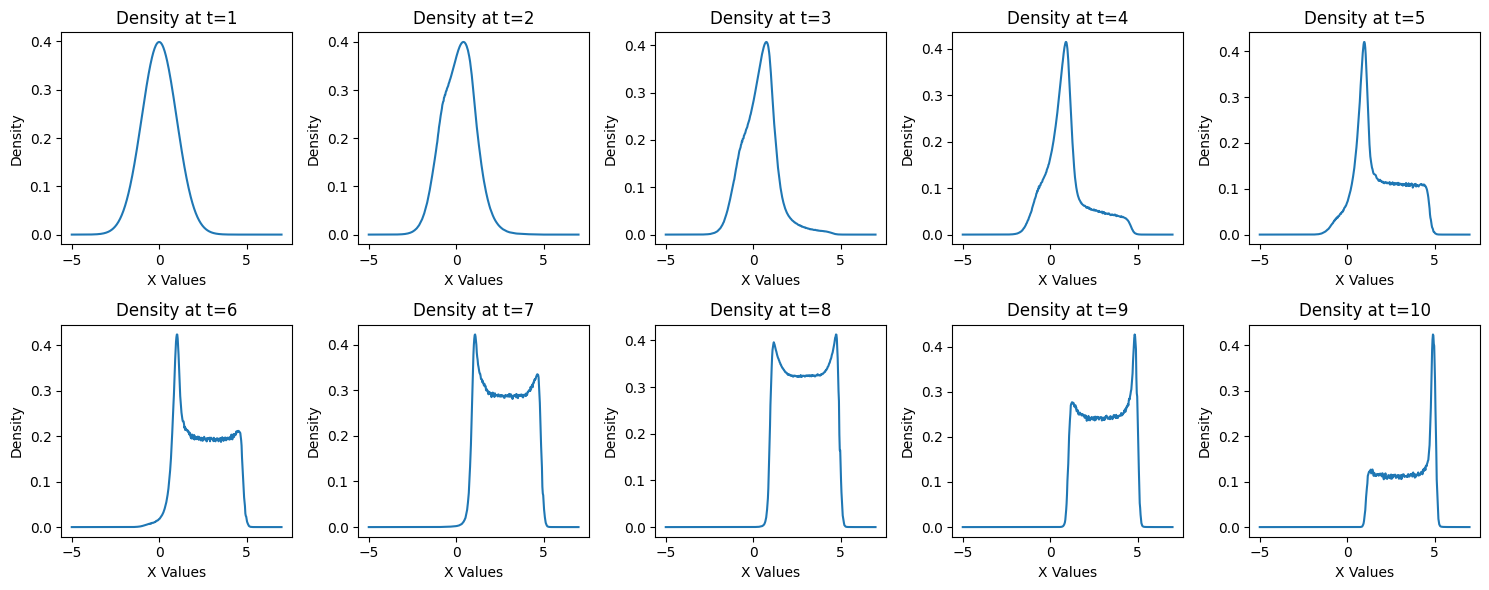

In [481]:
num_rows = 2
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

# Flatten the axes array to easily iterate over them
axes = axes.flatten()

# Iterate over each subplot and plot the corresponding density
for i, ax in enumerate(axes):
    ax.plot(compute_densities_at, ps[:,i])
    ax.set_title(f"Density at t={i+1}")
    ax.set_xlabel("X Values")
    ax.set_ylabel("Density")

# Adjust layout
plt.tight_layout()

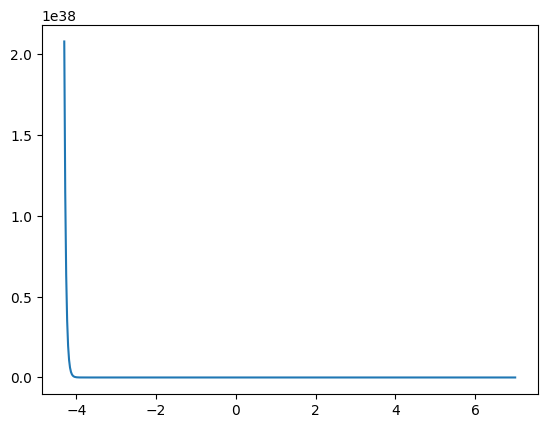

In [436]:
plt.plot(compute_densities_at, ps[:,9])

In [402]:
out_arr = jnp.asarray(outs)

In [403]:
mean_out = jnp.mean(out_arr, axis=0)

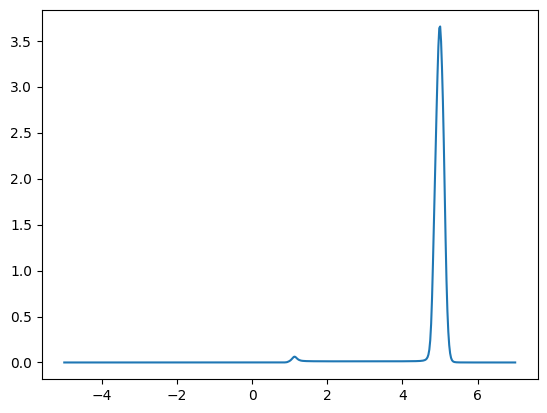

In [404]:
plt.plot(compute_densities_at, mean_out)

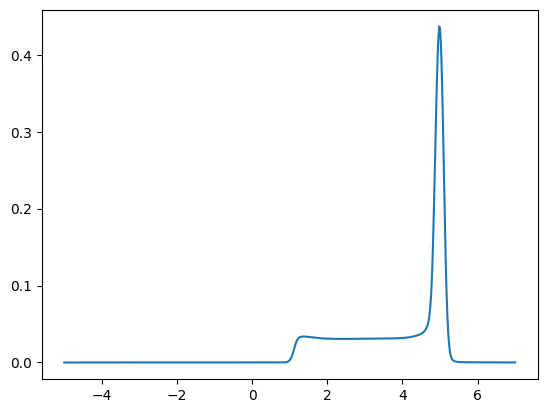

In [405]:
plt.plot(compute_densities_at, outs[0])

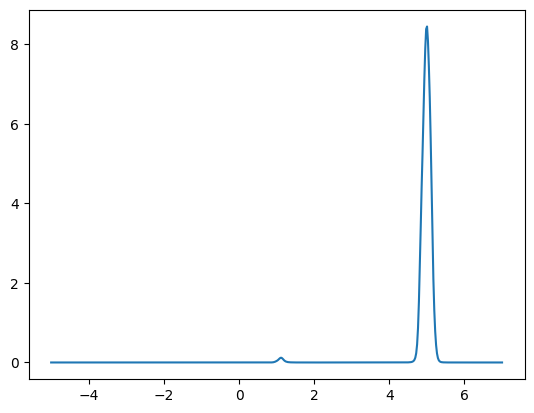

In [406]:
plt.plot(compute_densities_at, outs[1])

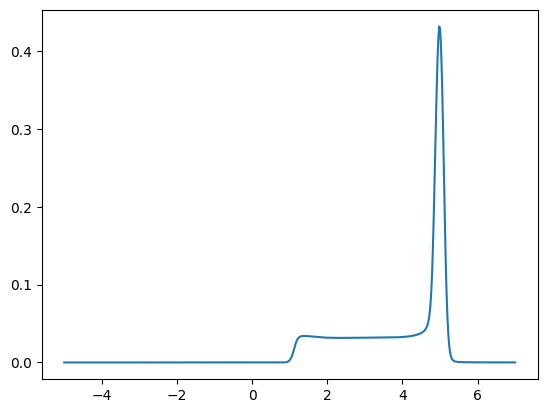

In [407]:
plt.plot(compute_densities_at, outs[2])

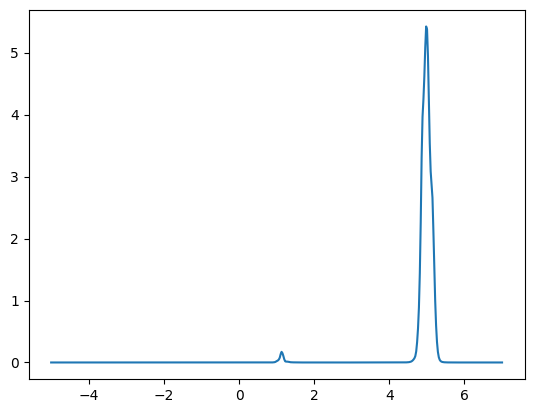

In [388]:
plt.plot(compute_densities_at, outs[3])

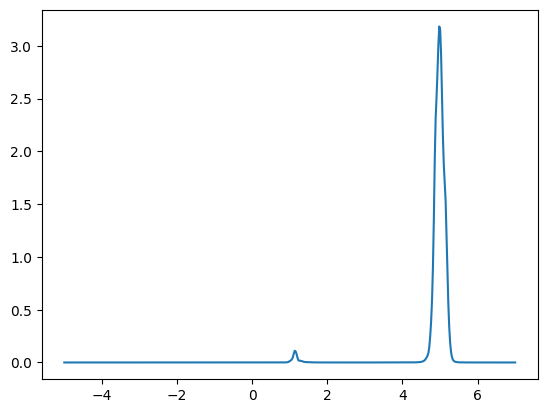

In [389]:
plt.plot(compute_densities_at, outs[4])

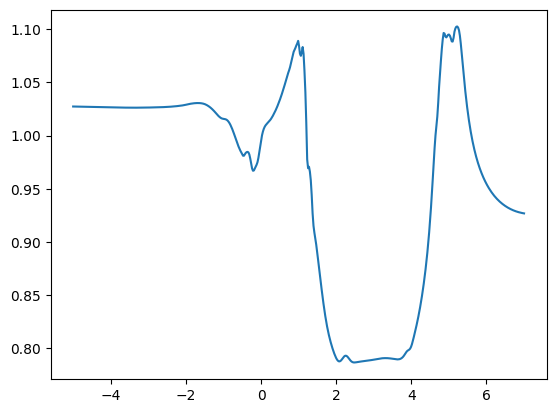

In [392]:
plt.plot(compute_densities_at, jnp.exp(f_0s[0]))

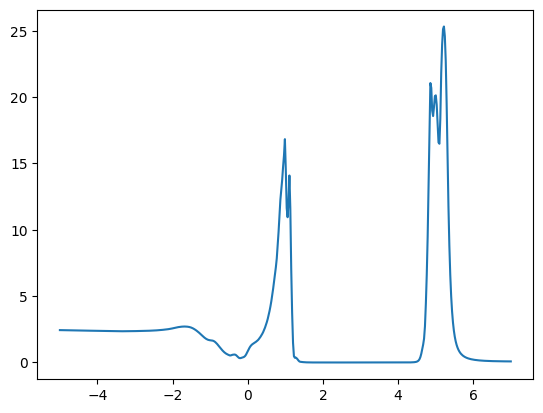

In [393]:
plt.plot(compute_densities_at, jnp.exp(f_0s[1]))

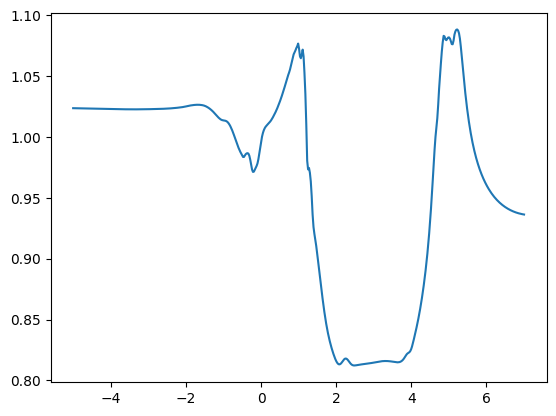

In [394]:
plt.plot(compute_densities_at, jnp.exp(f_0s[2]))

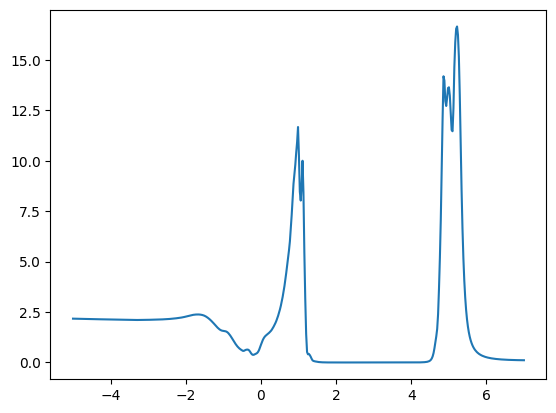

In [252]:
plt.plot(compute_densities_at, jnp.exp(f_0s[3]))

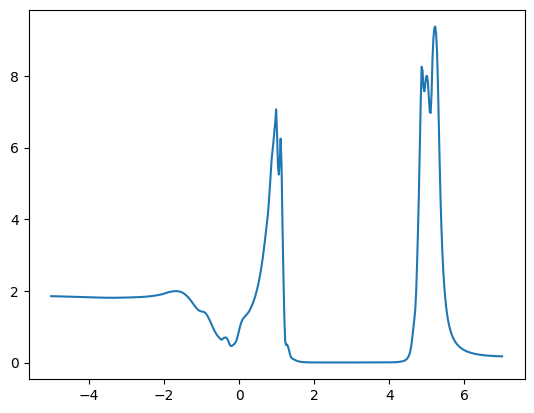

In [253]:
plt.plot(compute_densities_at, jnp.exp(f_0s[4]))

In [221]:
plt.plot(compute_densities_at, jnp.exp(outs[4]))

IndexError: list index out of range

In [154]:
compute_densities_at_2 = jax.random.choice(jax.random.PRNGKey(0), compute_densities_at, shape=(1000,), p=out)

In [160]:
df_x0=pd.DataFrame(x_0)
g = sns.kdeplot(df,
            x="x_0",
            fill=True,
            edgecolor="black",
            alpha=0.4,
        )

(1000, 1)

In [155]:
x_02, f_02, out2 = compute_densities(source, compute_densities_at_2, jax.random.PRNGKey(0))

In [156]:
import pandas as pd
df = pd.DataFrame(x_02, columns = ["x_0"])

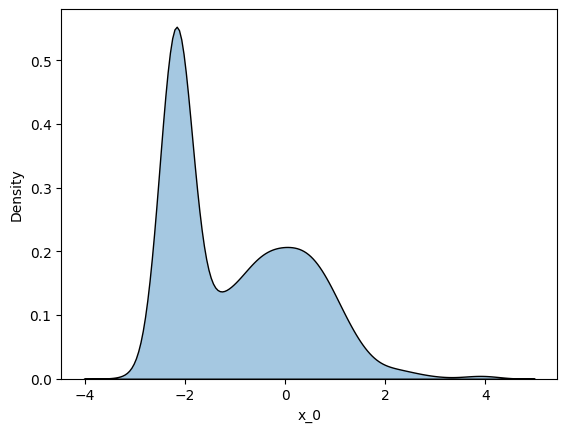

In [157]:
g = sns.kdeplot(df,
            x="x_0",
            fill=True,
            edgecolor="black",
            alpha=0.4,
        )